### In this homework assigment, you are required to apply the neural fitted Q-iteration algorithm to a pre-collected dataset for batch (offline) policy optimisation. Please follow the instructions detailed below.

Step 1: Generate an offline dataset. Consider the CartPole example. We will use a sub-optimal policy for data generation. Specifically, consider the following deterministic policy $\pi_b$ that returns 0 (left) if the pole angle is negative and 1 otherwise. To allow exploration, we set the behavior policy to be a mixture of $\pi_b$ and a uniform random policy. Specifically, the agent will follow the uniform random policy or $\pi_b$ with equal probability. We simulate 100 episodes under this policy. This yields the offline dataset.

Step 2: Fitted Q-iteration. We will apply the neural fitted Q-iteration (FQI) algorithm to this offline data to compute an optimal policy with three different choices of $\gamma$, corresponding to 0.95, 0.99 and 1. Please refer to Page 43 of Lecture 5 for the pseudocode of FQI in batch settings. We repeat the Q-iteration 20 times, e.g., apply supervised learning algorithms 20 times to learn the optimal Q-function. The initial Q-estimator can be set to a zero function. Each iteration yields a Q-estimator, based on which we can derive an estimated optimal policy. In total, we obtain 20 $\times$ 3 (3 choices of $\gamma$) different policies.

* To combine FQI with neural networks, we consider using the [MLPregressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) function. We can use the default neural network architecture (no need to specify no. of layers or no. of hidden nodes per layer). We may set the maximum number of iterations to 500.

* In this example, we only have two actions (either pushing the cart to the left or to the right). As such, it would be better to use the second type of value function approximators on Page 11 of Lecture 5 (e.g., for each action, use a separate model for the value). The last type of approximators would be preferred in settings where we have a large action space.

* The TD target depends on whether the current state is a terminal state or not. For a nonterminal state, the TD target is constructed as in the lecture slide. For a terminal state, the TD target is equal to the immediate reward.

Step 3: Policy evaluation. For each of the computed 60 policies, we use the Monte Carlo method to evaluate the expected return under this policy, by generating 1000 episodes. Finally, plot all the returns in a single figure and comment on the results.

In [1]:
import gymnasium as gym
import numpy as np

env = gym.make('CartPole-v1')

def pi_b(state):
    return 0 if state[2] < 0 else 1

offline_dat = {'state': [], 'action': [], 'reward': [], 'next_state': [], 'done': []}

for episode in range(100):
    state_info = env.reset()
    state = state_info[0] 
    done = False
    while not done:
        if np.random.rand() < 0.5:
            action = pi_b(state)
        else:
            action = env.action_space.sample()

        output = env.step(action)
        next_state, reward, done = output[0], output[1], output[2]
        
        offline_dat['state'].append(state)
        offline_dat['action'].append(action)
        offline_dat['reward'].append(reward)
        offline_dat['next_state'].append(next_state)
        offline_dat['done'].append(done)
        
        state = next_state

for key in offline_dat:
    offline_dat[key] = np.array(offline_dat[key])

print("Dataset generated with", len(offline_dat['state']), "entries.")


Dataset generated with 4213 entries.


In [2]:
from sklearn.neural_network import MLPRegressor

gammas = [0.95, 0.99, 1]

policies = {}

for gamma in gammas:
    Q_estimators = {
        0: MLPRegressor(max_iter=500, warm_start=True),
        1: MLPRegressor(max_iter=500, warm_start=True)
    }
    
    zero_target = np.zeros((len(offline_dat['state']),))
    Q_estimators[0].fit(offline_dat['state'], zero_target)
    Q_estimators[1].fit(offline_dat['state'], zero_target)
    
    for k in range(20):
        targets = []
        
        for state, action, reward, next_state, done in zip(
                offline_dat['state'], offline_dat['action'], offline_dat['reward'], offline_dat['next_state'], offline_dat['done']):
            
            if done:
                target = reward
            else:
                Q_values_next_state = [estimator.predict(next_state.reshape(1, -1))[0] for estimator in Q_estimators.values()]
                target = reward + gamma * np.max(Q_values_next_state)
            
            targets.append(target)
        
        targets = np.array(targets)
        
        for action in [0, 1]:
            indices = np.where(offline_dat['action'] == action)
            Q_estimators[action].fit(offline_dat['state'][indices], targets[indices])
    
    def policy(state):
        Q_values = [Q_estimators[action].predict(state.reshape(1, -1))[0] for action in [0, 1]]
        return np.argmax(Q_values)

    policies[gamma] = policy


In [3]:
def make_policy(Q_estimators):
    def policy(state_tuple):
        state_array = state_tuple[0] 
        reshaped_state = state_array.reshape(1, -1)

        Q_values = [Q_estimators[a].predict(reshaped_state)[0] for a in range(2)]
        return np.argmax(Q_values)
    return policy

policies = {gamma: make_policy(Q_estimators) for gamma in gammas}

# Function to run a single episode and compute total discouted reward
def run_episode(env, policy, gamma):
    state_info = env.reset()
    done = False
    total_reward = 0.0
    discount_factor = 1.0
    while not done:
        action = policy(state_info)
        output = env.step(action)
        state_info = (output[0], {})
        reward, done = output[1], output[2]
        total_reward += reward * discount_factor
        discount_factor *= gamma
    return total_reward

policy_returns = {}

for gamma in gammas:
    policy_returns[gamma] = []

for gamma in gammas:
    policy = policies[gamma]

    for j in range(1000):
        episode_return = run_episode(env, policy, gamma)
        policy_returns[gamma].append(episode_return)


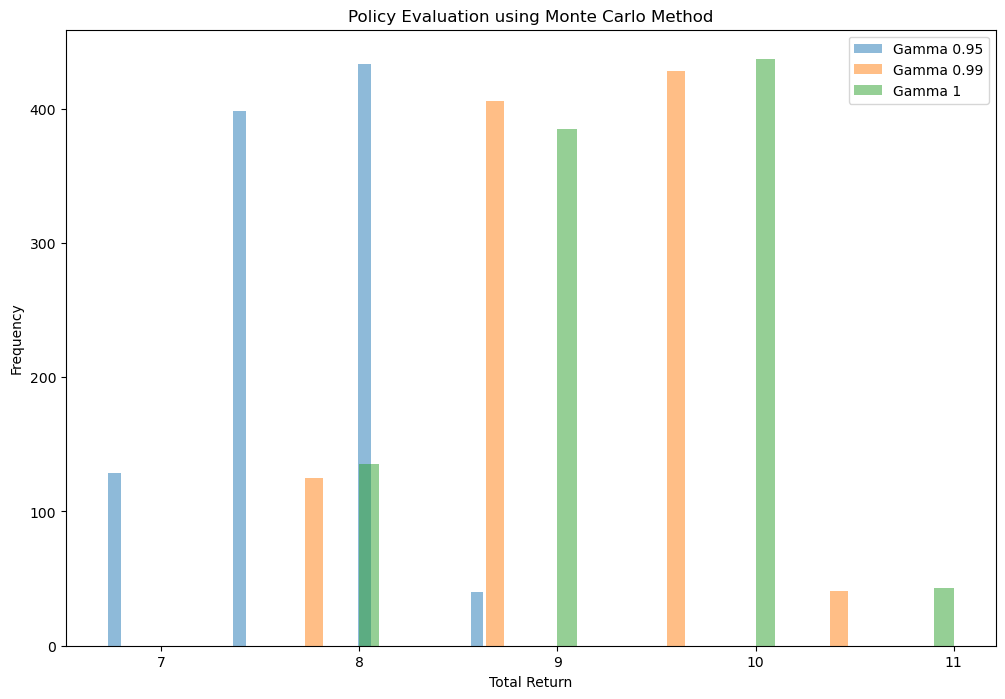

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for gamma, returns in policy_returns.items():
    plt.hist(returns, bins=30, alpha=0.5, label=f'Gamma {gamma}')
plt.title('Policy Evaluation using Monte Carlo Method')
plt.xlabel('Total Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Effect of Gamma: The different gamma values (0.95, 0.99, and 1) show varying peaks in returns. The gamma value influences how future rewards are discounted, with a higher gamma placing more emphasis on future rewards.

- Gamma 0.95: This policy seems to have a wider distribution and lower returns overall. This suggests that it migth be more short-sighted, prioritizing immediate rewards over future rewards.

- Gamma 0.99: This distribution is slightly shifted towards higher returns copared to gamma 0.95, indicating a more balanced approach between immediate and future rewards.

- Gamma 1: The policy with gamma set to 1 (no discounting) shows a distribution heavily skewed towards higher returns, which suggests that this policy is highly focused on the long-term accumulation of rewards. The fact that the distribution is narrow might also imply that the policy has learned to consistently perform actions that prevent the pole from falling over for a significant duration.

Overall, the plot looks a bit unusual, and I don't know why the returns are clustered around few values. However, the general outcome does have a interpretable structure inline with what we could expect.